# SENTENCE PAIRS CLASSIFICATION: GLOVE IMPLEMENTATION

### 1. DATA EXPLORATION

In [1]:
import numpy as np
import pandas as pd
import csv
import random

# Import packages for pre-processing
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

# Data Modelling
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Open drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Install kaggle
!pip install kaggle
# Setup kaggle config dir
!mkdir ~/.kaggle
# Copy kaggle API token to config dir
!cp ./gdrive/MyDrive/kaggle.json ~/.kaggle/
# Set access rights
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset
!kaggle competitions download -c contradictory-my-dear-watson

  0% 0.00/536k [00:00<?, ?B/s]
100% 536k/536k [00:00<00:00, 78.6MB/s]
  0% 0.00/66.0k [00:00<?, ?B/s]
100% 66.0k/66.0k [00:00<00:00, 65.8MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 69.8MB/s]


In [5]:
!mkdir data
!unzip train.csv.zip -d ./data
!unzip test.csv.zip -d ./data

Archive:  train.csv.zip
  inflating: ./data/train.csv        
Archive:  test.csv.zip
  inflating: ./data/test.csv         


In [6]:
# Load the train dataset
path = './data/'
train_data = pd.read_csv(path + 'train.csv', sep=",")
train_data = pd.DataFrame(train_data, columns=['premise', 'hypothesis', 'label'])
train_data.head()

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,0
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,1


In [7]:
# Load the test dataset
test_data = pd.read_csv(path + 'test.csv', sep=",")
test_data = pd.DataFrame(test_data, columns=['premise', 'hypothesis'])
test_data.head()

,premise,hypothesis
0,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی..."
1,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...
2,et cela est en grande partie dû au fait que le...,Les mères se droguent.
3,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。
4,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась."


In [8]:
# Labels distributions
print('==Labels train set:==\n{}'.format(train_data['label'].value_counts()))

==Labels train set:==
0    4176
2    4064
1    3880
Name: label, dtype: int64


### 2. DATA PRE-PROCESSING

In [9]:
# Download packages
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [10]:
lemmat = WordNetLemmatizer()

def clean_text(sentence, lemma=False):    

    # Step 1: Transform text to lower case, remove url, some punctuations and long repeated characters 
    sent = sentence.lower()
    sent = re.sub(r'(http:)\S+', r'', sent)
    sent = re.sub(r'[\.,`=_/#]', r' ', sent)
    sent = re.sub(r'(\w)\1{2,}', r'\1\1', sent)

    # Step 2: Find the tokens of each text and apply lemmatization
    tokens = word_tokenize(sent)
    if lemma: tokens = [lemmat.lemmatize(w) for w in tokens] 

    return ' '.join(tokens)

# Data Cleaning in both sets
train_data['clean_sent1'] = train_data['premise'].map(lambda x: clean_text(x, lemma=True))
train_data['clean_sent2'] = train_data['hypothesis'].map(lambda x: clean_text(x, lemma=True))


test_data['clean_sent1'] = test_data['premise'].map(lambda x: clean_text(x, lemma=True))
test_data['clean_sent2'] = test_data['hypothesis'].map(lambda x: clean_text(x, lemma=True))

### 3. TEXT VECTORIZATION

In [11]:
max_features = 300

# Fit the vectorizer to the pair of training data and transform it separetely
vectorizer = TfidfVectorizer(max_features = max_features, max_df = 0.5)

# Join pair of sentences
pair_train = [' '.join([s1,s2]) for s1,s2 in train_data[['clean_sent1', 'clean_sent2']].values]
train_vec = vectorizer.fit(pair_train)

In [25]:
# Transform sentence independently
X_train1 = train_vec.transform(train_data['clean_sent1'].values)
X_train2 = train_vec.transform(train_data['clean_sent2'].values)

#Vectorize test sentences
X_test1 = train_vec.transform(test_data['clean_sent1'].values)
X_test2 = train_vec.transform(test_data['clean_sent2'].values)

print(X_train1.shape)
print(X_train2.shape)

(12120, 300)
(12120, 300)


In [19]:
# Column with integer labels
dict_label = { 0 : 'entailment', 1 : 'neutral', 2 : 'contradiction' }
train_data['gold_label'] = train_data['label'].map(lambda x: dict_label[x])

### 4. SENTENCE SIMILARITY

In [13]:
# Create a Dictionary of labels with its cosine values
def dic_labels(x,y):
    
    dic = {
    'neutral': [],
    'entailment': [],
    'contradiction': []
    }
    
    for i,j in zip(x,y):
        if j == 'entailment':
            dic[j].append(i)
        elif j == 'neutral':
            dic[j].append(i)
        else:
            dic[j].append(i)
    
    return dic

In [17]:
train_data['label'].values

array([0, 2, 0, ..., 2, 2, 0])

In [20]:
# Compute distance metrics
cosine = lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
euclidean = lambda x,y: euclidean_distances(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]

train_data['dist_cos'] = list(map(cosine, X_train1, X_train2))
train_data['dist_euc'] = list(map(euclidean, X_train1, X_train2))

dist_cos = dic_labels(train_data['dist_cos'].values, train_data['gold_label'].values)
dist_euc = dic_labels(train_data['dist_euc'].values, train_data['gold_label'].values)

In [21]:
train_data.iloc[:5]

,premise,hypothesis,label,clean_sent1,clean_sent2,dist_cos,dist_euc,gold_label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,and these comment were considered in formulati...,the rule developed in the interim were put tog...,0.887788,0.473734,entailment
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,these are issue that we wrestle with in practi...,practice group are not permitted to work on th...,0.326311,1.160766,contradiction
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,0,de petite choses comme celles-là font une diff...,j'essayais d'accomplir quelque chose,0.000000,1.000000,entailment
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,you know they ca n't really defend themselves ...,they ca n't defend themselves because of their...,0.281338,1.198885,entailment
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,1,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,0.000000,0.000000,neutral


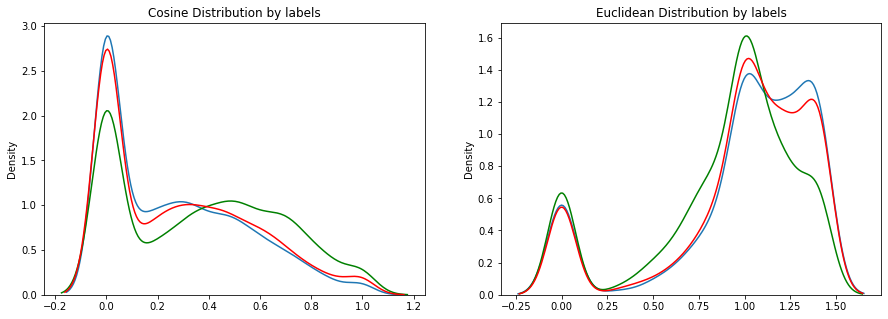

In [22]:
# Cosine scores distribution by labels
metric = ['Cosine', 'Euclidean']
results = [dist_cos, dist_euc]
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(0,2):
    sb.distplot(results[i]['neutral'], hist=False, ax=ax[i])
    sb.distplot(results[i]['entailment'], hist=False, color='green', ax=ax[i])
    sb.distplot(results[i]['contradiction'], hist=False, color='red', ax=ax[i])
    ax[i].set_title(metric[i] + ' Distribution by labels')

plt.show()


## 5. DATA MODELING. MULTI-CLASSIFICATION PROBLEM

In [26]:
# Transform saprse matrix to numpy
X_train1 = X_train1.todense().A
X_train2 = X_train2.todense().A

X_test1 = X_test1.todense().A
X_test2 = X_test2.todense().A

# The approach used to represent the input is going to be substraction (A sent_vector - B sent_vector)

X_train = []
N,_ = X_train1.shape
M,_ = X_test1.shape

for i in range(0,N):
    subs = X_train1[i] - X_train2[i]
    X_train.append(subs)
print('X_train Length:', len(X_train))
    
X_test = []
for i in range(0,M):
    subs = X_test1[i] - X_test2[i]
    X_test.append(subs)


y_train = np.array(train_data['label'].values)
#y_test = np.array(test_data['label'].values)
print('y_train Shape:', y_train.shape)

X_train Length: 12120
y_train Shape: (12120,)


In [27]:
class EstimatorSelectionHelper:
    
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys() # list of models' names
        self.grid_searches = {} ## empty dictionary for the Grid.fit of each model
    
    def fit(self, X, y, **grid_kwargs):
        for key in self.keys:
            print('Running GridSearchCV for %s.' % key)
            model = self.models[key]
            params = self.params[key]
            grid_search = GridSearchCV(model, params, **grid_kwargs, cv=3)
            grid_search.fit(X, y)
            self.grid_searches[key] = grid_search ## fitting output from gird_search
        print('Done.')
    
    def score_summary(self, sort_by='mean_test_score'):
        frames = []
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_) # The results for every combination of param
            frame = frame.filter(regex='^(?!.*param_).*$') # remove columns about GRID parameters
            frame['estimator'] = len(frame)*[name] # add the name of the model for every combo 
            frames.append(frame)
        df = pd.concat(frames) # final dict of all the training that the grid model has done
        
        df = df.sort_values([sort_by], ascending=False)
        df = df.reset_index()
        df = df.drop(['rank_test_score', 'index'], 1)
        
        # Reorder the columns so estimator is the first one
        columns = df.columns.tolist() 
        columns.remove('estimator') 
        columns = ['estimator']+columns 
        df = df[columns]
        return df

In [28]:
models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    'kNN': KNeighborsClassifier(n_jobs=-1),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

params = {
    'LogisticRegression': {'solver' : ['newton-cg', 'saga', 'sag'],
                          'C' : np.logspace(-10, 0, 10)
                          },
    'kNN': {'n_neighbors' : [3, 5, 10],
           'weights': ["uniform", "distance"]
           },
    'SVC': {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale']
           },
    'RandomForestClassifier': {'n_estimators': [10,50,100],
              'criterion': ['gini', 'entropy']
            }
}

In [29]:
t0 = time.time()

combined_results=pd.DataFrame()

helper = EstimatorSelectionHelper(models, params)

helper.fit(X_train, y_train, scoring='accuracy')
results = helper.score_summary()
combined_results = pd.concat([combined_results, results], ignore_index=True)

print('Time in minutes:', (time.time() - t0)/60)

Running GridSearchCV for LogisticRegression.
Running GridSearchCV for kNN.
Running GridSearchCV for SVC.
Running GridSearchCV for RandomForestClassifier.
Done.
Time in minutes: 18.315337447325387


In [30]:
# Display the results dataframe
results = results.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
cols = ['estimator', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
results = results[cols]
results.head(10)

,estimator,params,mean_test_score,mean_fit_time,mean_score_time
0,SVC,"{'C': 1, 'gamma': 'scale'}",0.425165,25.909233,12.052509
1,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 50}",0.423020,5.182827,0.207817
2,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 100}",0.419142,10.084418,0.307785
3,RandomForestClassifier,"{'criterion': 'entropy', 'n_estimators': 100}",0.414439,12.380223,0.307662
4,RandomForestClassifier,"{'criterion': 'entropy', 'n_estimators': 50}",0.414026,6.322327,0.207632
5,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'sag'}",0.408251,1.550511,0.010625
6,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'saga'}",0.408168,1.547162,0.011412
7,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'newton-cg'}",0.408168,1.512399,0.010590
8,SVC,"{'C': 10, 'gamma': 'auto'}",0.404785,26.774691,12.233248
9,LogisticRegression,"{'C': 0.005994842503189421, 'solver': 'sag'}",0.404538,1.536944,0.010993


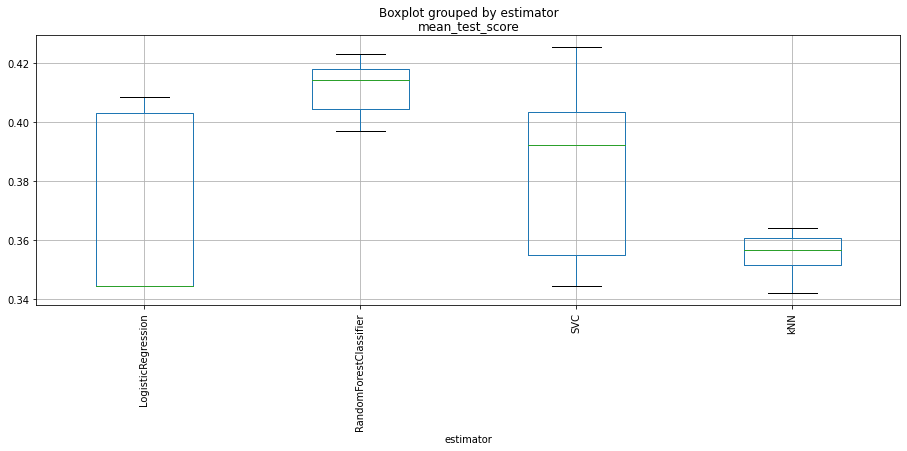

In [31]:
results.boxplot(column='mean_test_score',by='estimator', figsize=(15,5), rot=90)

### 6. ERROR ANALYSIS AND TEST RESULTS

In [33]:
# Predictions for the test set
param = results.loc[1, 'params']
top_model = RandomForestClassifier(**param)
top_model.fit(X_train,y_train)
y_pred = top_model.predict(X_test)
#print(classification_report(y_test, y_pred))
y_pred

array([2, 2, 2, ..., 0, 0, 0])

In [35]:
test_data.head()

,premise,hypothesis,clean_sent1,clean_sent2
0,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,کیسی کے لئے کوئی یادگار نہیں ہوگا کولمین ہائی ...
1,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,هذا هو ما تم نصحنا به,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...
2,et cela est en grande partie dû au fait que le...,Les mères se droguent.,et cela est en grande partie dû au fait que le...,le mères se droguent
3,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,与城市及其他公民及社区组织代表就ima的艺术发展进行对话 & amp,ima与其他组织合作，因为它们都依靠共享资金。
4,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",она все еще была там,мы думали что она ушла однако она осталась


In [36]:
# Export kaggle submission
outDf = pd.read_csv(path + 'test.csv', sep=",")
outDf = pd.DataFrame(outDf, columns=['id'])
outDf["prediction"] = y_pred
outDf.to_csv("kaggle_result1.csv", index=False)